In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from tqdm import tqdm
from src.dag import grn

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Dark2.colors)

%matplotlib inline

# Simulations

In [2]:
n_reps = 50
n_genes = 1000


if os.path.exists('figdata/fig2_grns.list.pkl') and os.path.exists('figdata/fig2_grns.parquet'):
    G_s = pickle.load(open('figdata/fig2_grns.list.pkl', 'rb'))
    grns = pd.read_parquet('figdata/fig2_grns.parquet')
else:
    iterator = list(itertools.product([n_genes], [3, 6, 12], [0.2, 0.4, 0.8], range(n_reps)))

    G_s = [grn().add_er_structure(
                     n, 
                     r=r
               ).add_expression_parameters(
                     sign = np.random.choice([-1, 1], p=[0.5, 0.5], size=(n, n)),
                     weight = gamma
               ).compute_h2()
           for n, r, gamma, _ in tqdm(iterator)]
    pickle.dump(G_s, open('figdata/fig2_grns.list.pkl', 'wb'))

    grns = pd.DataFrame([{
        'n': n,
        'r': r,
        'gamma': gamma,
        'cish2': G.cish2
    } for (n, r, gamma, _), G in zip(iterator, G_s)])
    grns.to_parquet('figdata/fig2_grns.parquet')

display(len(G_s), grns.head(2))

<IPython.core.display.Javascript object>

100%|██████████████████████████████████████████████████████████████████████████████████████| 450/450 [09:19<00:00,  1.24s/it]


<IPython.core.display.Javascript object>

450

,n,r,gamma,cish2
0,1000,3,0.2,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,1000,3,0.2,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


# Figure 2

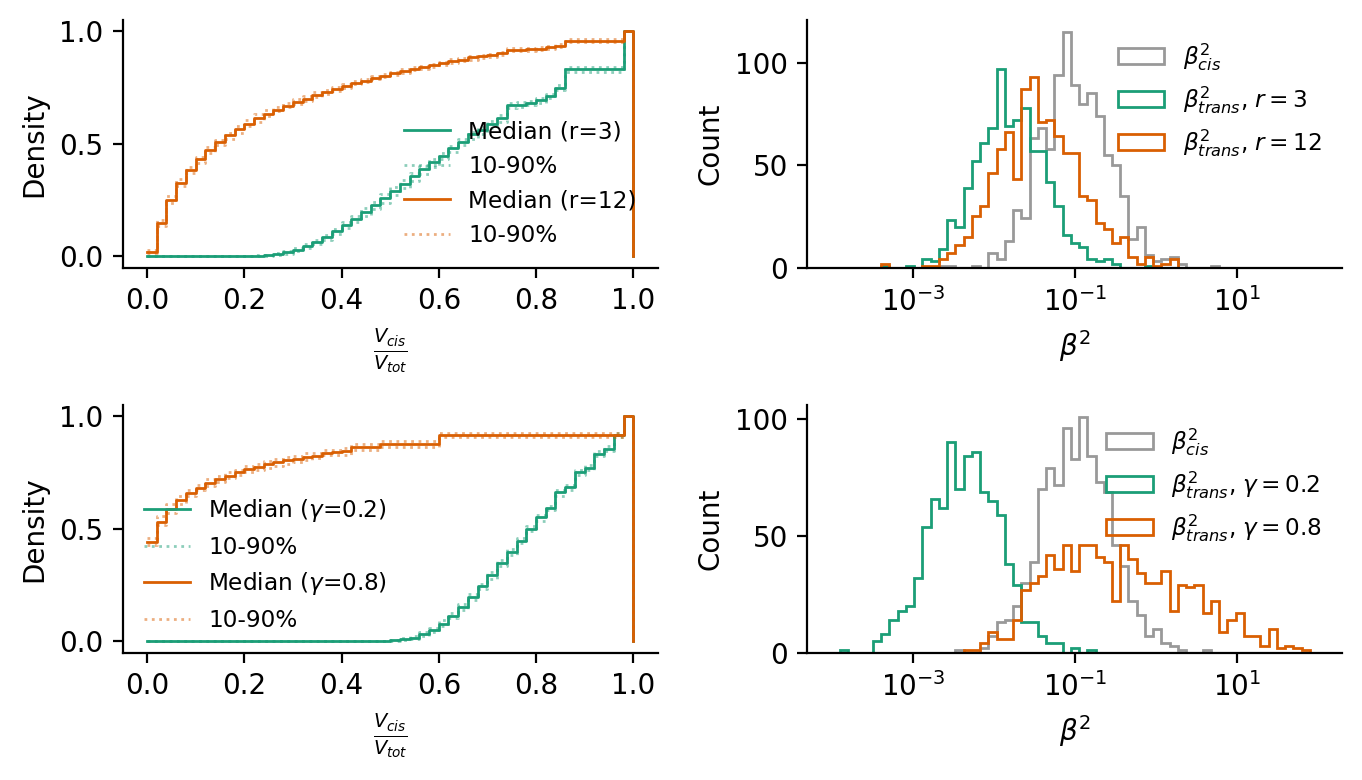

In [3]:
fig, axs = plt.subplots(2, 2, figsize=(7, 4), dpi=200)

# heritability <> sparsity
ax = axs[0,1]
x_bins = np.linspace(0, 1, 51)

for i,r in enumerate([3, 12]):
    y_vals = np.quantile(grns.loc[(grns.r == r) & (grns.gamma == 0.4), 'cish2'].apply(lambda x: np.cumsum(np.histogram(x, bins = x_bins)[0])).tolist(), q=[0.1, 0.5, 0.9], axis=0)
    c = plt.get_cmap('Dark2')(i)
    for y, par in zip(y_vals, [{'c':c, 'alpha':0.5, 'linestyle':'dotted', 'linewidth':1.0, 'label':''},
                               {'c':c, 'alpha':1.0, 'linestyle':'solid', 'linewidth':1.0, 'label':'Median (r={})'.format(int(r))},
                               {'c':c, 'alpha':0.5, 'linestyle':'dotted', 'linewidth':1.0, 'label':'10-90%'}]):
        ax.step(x_bins, np.hstack([y, 0]) / n_genes, where='post', **par);

ax.set_xlabel(r'$\frac{V_{cis}}{V_{tot}}$');
ax.set_ylabel('Density');
ax.legend(fontsize='small', frameon=False);


# heritability <> regulation strength
ax = axs[1,1]
for i,gamma in enumerate([0.2, 0.8]):
    y_vals = np.quantile(grns.loc[(grns.r == 6) & (grns.gamma == gamma), 'cish2'].apply(lambda x: np.cumsum(np.histogram(x, bins = x_bins)[0])).tolist(), q=[0.1, 0.5, 0.9], axis=0)
    c = plt.get_cmap('Dark2')(i)
    for y, par in zip(y_vals, [{'c':c, 'alpha':0.5, 'linestyle':'dotted', 'linewidth':1.0, 'label':''},
                               {'c':c, 'alpha':1.0, 'linestyle':'solid', 'linewidth':1.0, 'label':'Median ({0}={1})'.format(r'$\gamma$', gamma)},
                               {'c':c, 'alpha':0.5, 'linestyle':'dotted', 'linewidth':1.0, 'label':'10-90%'}]):
        ax.step(x_bins, np.hstack([y, 0]) / n_genes, where='post', **par);

ax.set_xlabel(r'$\frac{V_{cis}}{V_{tot}}$');
ax.set_ylabel('Density');
ax.legend(fontsize='small', frameon=False);


# eQTLs <> sparsity
ax = axs[0,0]

V_cis = np.random.lognormal(np.log(0.1), 1, size=(1000,))
ax.hist(V_cis, 
        histtype='step', 
        bins=np.geomspace(1e-4, 1e2, 60),
        alpha=0.8,
        color='gray',
        label=r'$\beta^2_{cis}$'
);

for r in [3, 12]:
    row = grns.query('gamma == 0.4 & r == @r').sample(1).iloc[0]

    G = G_s[row.name]
    G.compute_h2(np.ones(G.n));
    V_trans = (G.L @ np.diag(np.sqrt(V_cis))) ** 2

    ax.hist((V_trans - np.diag(np.diag(V_trans))).max(axis=0), 
             histtype='step', 
             bins=np.geomspace(1e-4, 1e2, 60),
             label=r'$\beta^2_{trans}$'+', '+r'$r=$'+str(row.r)
            );
    
ax.legend(fontsize='small', frameon=False);
ax.set_xscale('log');
ax.set_xlabel(r'$\beta^2$'); 
ax.set_ylabel('Count');


# eQTLs <> reg. architecture
ax = axs[1,0]

V_cis = np.random.lognormal(np.log(0.1), 1, size=(1000,))
ax.hist(V_cis, 
        histtype='step', 
        bins=np.geomspace(1e-4, 1e2, 60),
        alpha=0.8,
        color='gray',
        label=r'$\beta^2_{cis}$'
);

for gamma in [0.2, 0.8]:
    row = grns.query('gamma == @gamma & r == 6').sample(1).iloc[0]
    G = G_s[row.name]

    G.compute_h2(np.ones(G.n));
    V_trans = (G.L @ np.diag(np.sqrt(V_cis))) ** 2

    ax.hist((V_trans - np.diag(np.diag(V_trans))).max(axis=0), 
             histtype='step', 
             bins=np.geomspace(1e-4, 1e2, 60),
             label=r'$\beta^2_{trans}$'+', '+r'$\gamma=$'+str(row.gamma)
            );
    
ax.legend(fontsize='small', frameon=False);
ax.set_xscale('log');
ax.set_xlabel(r'$\beta^2$'); 
ax.set_ylabel('Count');


# overall figure stuff
sns.despine();
fig.tight_layout();

# Supplement

## Leading trans effects (out) follow cis effect size

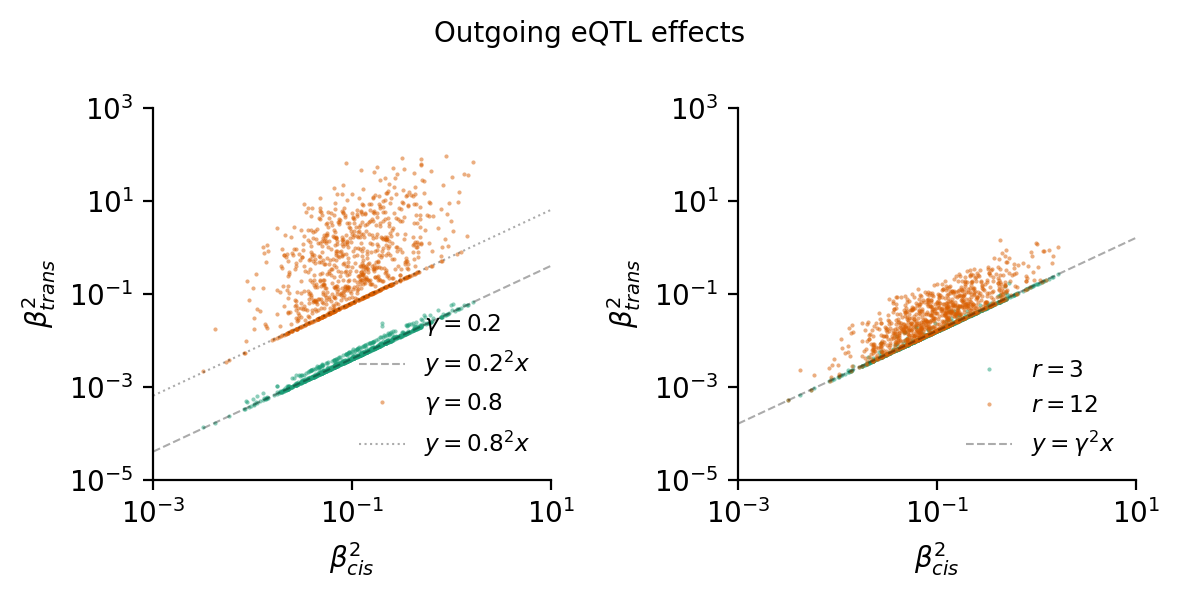

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(6,3), dpi=200);

V_cis = np.random.lognormal(np.log(0.1), 1, size=(1000,))

xl = np.array([1e-3,1e1])
yl = np.array([1e-5,1e3])

ax = axs[0]

for gamma in [0.2, 0.8]:
    row = grns.query('gamma == @gamma & r == 6').sample(1).iloc[0]
    G = G_s[row.name]

    G.compute_h2(np.ones(G.n));
    V_trans = (G.L @ np.diag(np.sqrt(V_cis))) ** 2

    ax.plot(V_cis, (V_trans - np.diag(np.diag(V_trans))).max(axis=0),
             '.',
             alpha=0.5,
             ms=1,
             label=r'$\gamma=$'+str(row.gamma)
            );
    
    if gamma == 0.2:
        ax.plot(xl, gamma**2 * xl, 'k--', alpha=0.33, linewidth=0.75, label=r'$y = 0.2^2 x$');
    if gamma == 0.8:
        ax.plot(xl, gamma**2 * xl, 'k:', alpha=0.33, linewidth=0.75, label=r'$y = 0.8^2 x$');


    
ax.legend(fontsize='small', frameon=False, loc='lower right');
ax.set_xscale('log');
ax.set_yscale('log');
ax.set_xlabel(r'$\beta^2_{cis}$'); 
ax.set_ylabel(r'$\beta^2_{trans}$'); 
ax.set_xlim(xl);
ax.set_ylim(yl);



ax = axs[1]

for r in [3, 12]:
    row = grns.query('gamma == 0.4 & r == @r').sample(1).iloc[0]
    G = G_s[row.name]

    G.compute_h2(np.ones(G.n));
    V_trans = (G.L @ np.diag(np.sqrt(V_cis))) ** 2

    ax.plot(V_cis, (V_trans - np.diag(np.diag(V_trans))).max(axis=0),
             '.',
             alpha=0.5,
             ms=1,
             label=r'$r=$'+str(row.r)
            );
    
ax.plot(xl, 0.4**2 * xl, 'k--', alpha=0.33, linewidth=0.75, label=r'$y = \gamma^2 x$');

ax.legend(fontsize='small', frameon=False, loc='lower right');
ax.set_xscale('log');
ax.set_yscale('log');
ax.set_xlabel(r'$\beta^2_{cis}$'); 
ax.set_ylabel(r'$\beta^2_{trans}$'); 
ax.set_xlim(xl);
ax.set_ylim(yl);


fig.suptitle('Outgoing eQTL effects', fontsize='medium');
fig.tight_layout();
sns.despine();

## Leading trans effects (in) don't follow cis effects

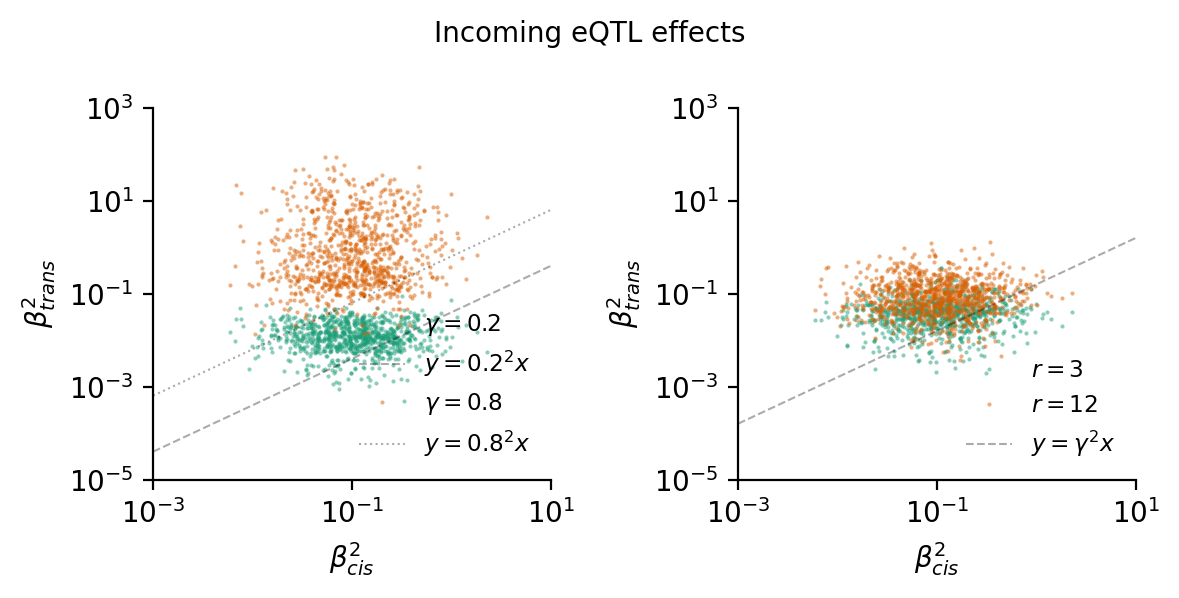

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(6,3), dpi=200);

V_cis = np.random.lognormal(np.log(0.1), 1, size=(1000,))

xl = np.array([1e-3,1e1])
yl = np.array([1e-5,1e3])

ax = axs[0]

for gamma in [0.2, 0.8]:
    row = grns.query('gamma == @gamma & r == 6').sample(1).iloc[0]
    G = G_s[row.name]

    G.compute_h2(np.ones(G.n));
    V_trans = (G.L @ np.diag(np.sqrt(V_cis))) ** 2

    ax.plot(V_cis, (V_trans - np.diag(np.diag(V_trans))).max(axis=1),
             '.',
             alpha=0.5,
             ms=1,
             label=r'$\gamma=$'+str(row.gamma)
            );
    
    if gamma == 0.2:
        ax.plot(xl, gamma**2 * xl, 'k--', alpha=0.33, linewidth=0.75, label=r'$y = 0.2^2 x$');
    if gamma == 0.8:
        ax.plot(xl, gamma**2 * xl, 'k:', alpha=0.33, linewidth=0.75, label=r'$y = 0.8^2 x$');


    
ax.legend(fontsize='small', frameon=False, loc='lower right');
ax.set_xscale('log');
ax.set_yscale('log');
ax.set_xlabel(r'$\beta^2_{cis}$'); 
ax.set_ylabel(r'$\beta^2_{trans}$'); 
ax.set_xlim(xl);
ax.set_ylim(yl);



ax = axs[1]

for r in [3, 12]:
    row = grns.query('gamma == 0.4 & r == @r').sample(1).iloc[0]
    G = G_s[row.name]

    G.compute_h2(np.ones(G.n));
    V_trans = (G.L @ np.diag(np.sqrt(V_cis))) ** 2

    ax.plot(V_cis, (V_trans - np.diag(np.diag(V_trans))).max(axis=1),
             '.',
             alpha=0.5,
             ms=1,
             label=r'$r=$'+str(row.r)
            );
    
ax.plot(xl, 0.4**2 * xl, 'k--', alpha=0.33, linewidth=0.75, label=r'$y = \gamma^2 x$');

ax.legend(fontsize='small', frameon=False, loc='lower right');
ax.set_xscale('log');
ax.set_yscale('log');
ax.set_xlabel(r'$\beta^2_{cis}$'); 
ax.set_ylabel(r'$\beta^2_{trans}$'); 
ax.set_xlim(xl);
ax.set_ylim(yl);


fig.suptitle('Incoming eQTL effects', fontsize='medium');
fig.tight_layout();
sns.despine();